In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, l2norm
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.ksd.kernel import l2norm

from src.sensors import Sensor, SensorImproper, norm2

MCMCKernel = RandomWalkMH # RandomWalkBarker 

2022-05-06 10:12:07.939205: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-06 10:12:07.939262: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-05-06 10:12:07.939269: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-05-06 10:12:07.939398: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-05-06 10:12:07.939424: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-05-06 10:12:07.939429: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-05-06 10:12:07.939866: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

model class: original ; dim: 16
loading data from res/sensors/res_ram_improper.csv


# Pompe's paper

In [182]:
tf.random.set_seed(1)

In [183]:
loc_true = tf.constant([
    [0.125, 0.81],
    [0.225, 0.475],
    [0.35, 0.1],
    [0.45, 0.22],
    [0.55, 0.73],
    [0.57, 0.93],
    [0.85, 0.05],
    [0.85, 0.8],
    [0.3, 0.7],
    [0.5, 0.3], 
    [0.7, 0.7],])

dist_true = tf.math.sqrt(l2norm(loc_true, loc_true))
dist_noise = tf.random.normal((loc_true.shape[0], loc_true.shape[0])) * 0.02
assert dist_noise.shape == (11, 11)
dist_noise = tf.experimental.numpy.triu(dist_noise, 1)
dist_noise += tf.transpose(dist_noise)
dist_true += dist_noise
assert tf.experimental.numpy.allclose(dist_true, tf.transpose(dist_true))

# Observation indicators for the sensors
## potentially wrong links (1 -- 11): 
## (3, 8)
O_true = tf.constant([
    [0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
    [1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
    [0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
    [0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.],
    [0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.],
    [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
    [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
    [1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
    [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
])
assert tf.experimental.numpy.allclose(O_true, tf.transpose(O_true))

# Observation indicators from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Ob = O_true[:8, 8:] # 8 x 3

# Observation indicators among the first four sensors. 
Os = O_true[:8, :8] # 8 x 8

# Each row indicates the location of the known sensors (9th to 11th).
Xb = loc_true[8:] # 3 x 2

# Each row indicates the location of the unknown sensors (1st to 8th).
Xs = loc_true[:8] # 8 x 2

# The observed distances from the observed sensors (each col) to the unobserved sensors.
Yb = (dist_true * O_true)[:8, 8:] # 8 x 3

# Observed distances among the first 8 sensors.
Ys = (dist_true * O_true)[:8, :8] # 8 x 8

In [184]:
target = SensorImproper(Ob, Os, Xb, Xs, Yb, Ys)
log_prob_fn = target.log_prob

In [185]:
tf.random.set_seed(1)

loc = tf.random.uniform((1, 16))
loc2 = tf.concat([loc, loc, loc], axis=0)
pp2 = log_prob_fn(loc2) - 25.
print(pp2)

loc3 = tf.concat([loc2, loc2], axis=0)
pp3 = log_prob_fn(loc3) - 25.
print(pp3)

tf.Tensor([-1403.2504 -1403.2504 -1403.2504], shape=(3,), dtype=float32)
tf.Tensor([-1403.2504 -1403.2504 -1403.2504 -1403.2504 -1403.2504 -1403.2504], shape=(6,), dtype=float32)


In [186]:
tf.random.set_seed(1)

loc = tf.random.uniform((1, 16))
loc2 = tf.concat([loc, loc, loc], axis=0)
pp2_2 = target.log_prob2(loc2) - 25.
print(pp2_2)

print(tf.experimental.numpy.allclose(pp2, pp2_2))

loc3 = tf.concat([loc2, loc2], axis=0)
pp3_2 = target.log_prob2(loc3) - 25.
print(pp3_2)
print(tf.experimental.numpy.allclose(pp3, pp3_2))

tf.Tensor([-1403.2502 -1403.2502 -1403.2502], shape=(3,), dtype=float32)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor([-1403.2502 -1403.2502 -1403.2502 -1403.2502 -1403.2502 -1403.2502], shape=(6,), dtype=float32)
tf.Tensor(True, shape=(), dtype=bool)


In [ ]:
import time

loc = tf.random.uniform((100, 16))

start = time.time()
pp = target.log_prob(loc)
end = time.time()
print(end - start)

# start = time.time()
# pp2 = target.log_prob2(loc)
# end = time.time()
# print(end - start)

print(tf.experimental.numpy.allclose(pp, pp2))

In [6]:
dim = 16

n = 1000
ind = tf.range(start=0, limit=200000, delta=200000//n)
# ind = tf.range(start=0, limit=100000, delta=100000//n)
# ind = range(n)

mcmc_res = pd.read_csv("res/sensors/res_ram_improper.csv")
samples_off = tf.constant(mcmc_res.loc[ind].to_numpy(), dtype=tf.float32)

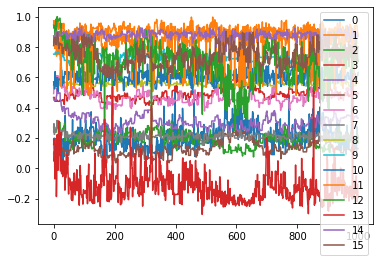

In [26]:
# autocorrelation
# plt.plot(range(samples_off.shape[0]), tfp.stats.auto_correlation(samples_off, axis=0)[:, 0])
for j in range(dim):
    plt.plot(range(samples_off.shape[0]), samples_off[:, j], label=f"{j}")
_ = plt.legend()

In [8]:
def plot_sensors(x, lims=None, loc_true=None, extra=None):
    n = x.shape[0]
    nsensors = loc_true.shape[0]
    
    x = tf.reshape(x, (n*nsensors, 2)).numpy()
    loc_true_np = tf.reshape(loc_true, (nsensors, 2)).numpy()
    sensors_ind = [str(i) for i in range(1, nsensors+1)]
    
    plot_df = pd.DataFrame({"x0": x[:, 0], "x1": x[:, 1], 
                            "sensor": sensors_ind * n})
    loc_true_df = pd.DataFrame({"x0": loc_true_np[:, 0], "x1": loc_true_np[:, 1],
                            "sensor": sensors_ind})
    
    sns.scatterplot(data=plot_df, x="x0", y="x1", hue="sensor")
    plt.scatter(loc_true_df["x0"], loc_true_df["x1"], color="black", marker="v")

    if extra is not None:
        extra_np = tf.reshape(extra, (-1, 2)).numpy()
        plt.scatter(extra_np[:, 0], extra_np[:, 1], color="grey", marker="P")
    
    if lims is not None:
        _ = plt.axis(xmin=lims[0], xmax=lims[1], ymin=lims[2], ymax=lims[3])
        

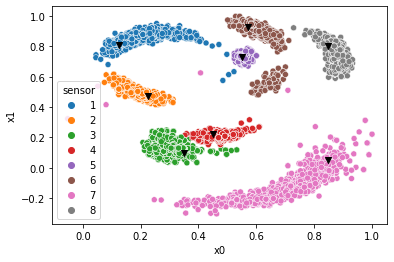

In [9]:
plot_sensors(samples_off, 
#              lims=[-0.1, 1.1, -0.1, 1,1], 
             loc_true=loc_true[:8], 
)

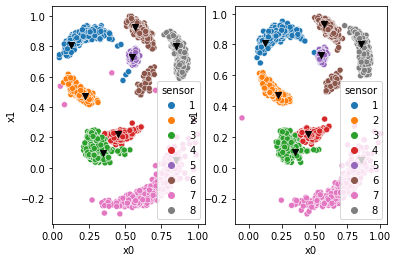

In [10]:
tf.random.set_seed(1)

ntrain = n // 2

samples_init = samples_off

samples_init = tf.random.shuffle(samples_init) # shuffle
# samples_init = samples_init[::-1] #!

sample_off_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]

# sample_off_train = sample_off_train[sample_off_train[:, 11] > 0.7]

plt.subplot(1, 2, 1)
plot_sensors(sample_off_train, loc_true=loc_true[:8])
plt.subplot(1, 2, 2)
plot_sensors(sample_off_test, loc_true=loc_true[:8])
plt.show()

In [11]:
threshold = 1e-4

# start_pts = sample_off_train
start_pts = tf.concat([
        sample_off_train[:(ntrain//2)], 
        tf.random.uniform(shape=(ntrain//2, dim), minval=-1., maxval=1.),
    ], axis=0)

tic = time.perf_counter()
mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold,
                                      max_iterations=500) #1e-10)
toc = time.perf_counter()
print(f"Optimisation finished in {toc - tic:0.4f} seconds")
len(mode_list)

end pts 500
Optimisation finished in 386.8224 seconds


8

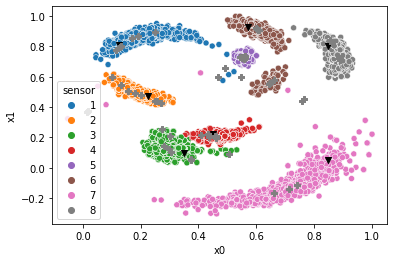

In [12]:
plot_sensors(samples_off, 
#              lims=[-0.1, 1.1, -0.1, 1,1], 
             loc_true=loc_true[:8], 
             extra=tf.stack(mode_list)
)

In [13]:
mode_list, inv_hess_list

([<tf.Tensor: shape=(16,), dtype=float32, numpy=
  array([ 0.17084323,  0.8524779 ,  0.20058379,  0.47773343,  0.30482677,
          0.10469098,  0.45959806,  0.20881972,  0.5592935 ,  0.7274836 ,
          0.60783356,  0.9108061 ,  0.74165905, -0.11652367,  0.88980913,
          0.7076626 ], dtype=float32)>,
  <tf.Tensor: shape=(16,), dtype=float32, numpy=
  array([ 0.18952319,  0.86592025,  0.18228088,  0.48941332,  0.29988548,
          0.12089954,  0.46235037,  0.20873728,  0.55802286,  0.7164769 ,
          0.6445561 ,  0.5520395 ,  0.71314305, -0.14153232,  0.88789564,
          0.7247308 ], dtype=float32)>,
  <tf.Tensor: shape=(16,), dtype=float32, numpy=
  array([ 0.49191827,  0.6565504 ,  0.15793146,  0.5088121 ,  0.28207502,
          0.14112024,  0.4558059 ,  0.20907937,  0.5549709 ,  0.72889966,
          0.6039655 ,  0.9146593 ,  0.66142654, -0.16888128,  0.88762647,
          0.72391343], dtype=float32)>,
  <tf.Tensor: shape=(16,), dtype=float32, numpy=
  array([0.2498986

In [ ]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

std = [1., 1.048]

T = 10

xx = sample_off_train#[sample_off_train[:, 0] < 0.3]

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=xx, ind_pair_list=ind_pair_list, **proposal_dict)

In [ ]:
if len(std) > 1:
    x_all = mh.x[0]
else:
    x_all = mh.x

x_0 = x_all[0, :, :].numpy()
x_t = x_all[-1, :, :].numpy()

x0_df = pd.DataFrame({f"x{i}": x_0[:, i] for i in range(dim)})
x0_df["type"] = "init"

xt_df = pd.DataFrame({f"x{i}": x_t[:, i] for i in range(dim)})
xt_df["type"] = "final"

xtrain_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
xtrain_df["type"] = "mcmc"


perturbed_df = pd.concat([
#     xtrain_df, 
    x0_df, 
    xt_df], ignore_index=True)

_ = sns.jointplot(data=perturbed_df, x="x10", y="x11", hue="type",
                  xlim=(-.1, 1.),
                  ylim=(-.1, 1.),
 )

In [ ]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [ ]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

In [33]:
_, p_val_no_pert = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)

_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert, "\nafter:", p_val)

before:  0.0 
after: 0.0


# Van Dyk's paper

In [161]:
# Observation indicators from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Ob = tf.constant([1., 0, 1, 0, 1, 0, 1, 0])
Ob = tf.transpose(tf.reshape(Ob, (2, -1)))

# Observation indicators among the first four sensors. 
Os = tf.constant([[0., 0, 0, 1],
              [0, 0, 1, 1],
              [0, 1, 0, 0],
              [1, 1, 0, 0]])

# Each row indicates the location of the known sensors (5th and 6th).
Xb = tf.constant([0.5, 0.3, 0.3, 0.7])
Xb = tf.transpose(tf.reshape(Xb, (2, -1)))

# Each row indicates the location of the unknown sensors (1st, 2nd, 3rd, and 4th).
Xs = tf.constant([0.5748, 0.0991, 0.2578, 0.8546, 
               0.9069, 0.3651, 0.1350, 0.0392])
Xs = tf.transpose(tf.reshape(Xs, (2, -1)))

# The observed distances from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Yb = tf.constant([0.6103, 0, 0.2995, 0, 
               0.3631, 0, 0.5656, 0])
Yb = tf.transpose(tf.reshape(Yb, (2, -1)))

# Observed distances among the first four sensors.
Ys = tf.constant([[0, 0, 0, 0.9266],
               [0, 0, 0.2970, 0.8524],
               [0, 0.2970, 0, 0],
               [0.9266, 0.8524, 0, 0]])

loc_true = tf.constant([
    [0.57, 0.91],
    [0.10, 0.37],
    [0.26, 0.14],
    [0.85, 0.04],
#     [0.50, 0.30],
#     [0.30, 0.70]
])

In [162]:
tf.random.set_seed(1)

loc = tf.random.uniform((2, 8))

target = Sensor(Ob, Os, Xb, Xs, Yb, Ys)
log_prob_fn = target.log_prob

loc2 = tf.concat([loc, loc, loc], axis=0)
log_prob_fn(loc2)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-689.25555, -365.59918, -689.25555, -365.59918, -689.25555,
       -365.59918], dtype=float32)>

In [181]:
import time

# tf.random.set_seed(1)
loc = tf.random.uniform((100, 8))

start = time.time()
pp = target.log_prob(loc)
end = time.time()
print(end - start)

start = time.time()
pp2 = target.log_prob2(loc)
end = time.time()
print(end - start)

print(tf.experimental.numpy.allclose(pp, pp2))

0.021805286407470703
0.0037183761596679688
tf.Tensor(True, shape=(), dtype=bool)


In [4]:
dim = 8

n = 2000
# ind = tf.range(start=0, limit=200000, delta=200000//n)
ind = tf.range(start=0, limit=100000, delta=100000//n)

mcmc_res = pd.read_csv("res/sensors/res_ram.csv")
# mcmc_res = pd.read_csv("res/sensors/res_mt.csv")
samples_off = tf.constant(mcmc_res.loc[ind].to_numpy(), dtype=tf.float32)

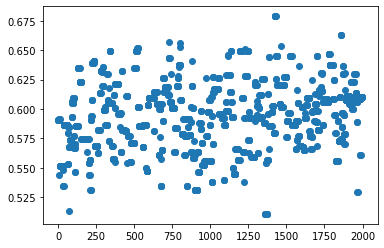

In [5]:
# samples_off = mcmc_res.to_numpy()
_ = plt.scatter(range(samples_off.shape[0]), samples_off[:, 0])

In [6]:
def plot_sensors(x, lims=None):
    n = x.shape[0]
    x = tf.reshape(x, (n*4, 2)).numpy()
    loc_true_np = tf.reshape(loc_true, (4, 2)).numpy()
    plot_df = pd.DataFrame({"x0": x[:, 0], "x1": x[:, 1], 
                            "sensor": ["1", "2", "3", "4"] * n})
    loc_true_df = pd.DataFrame({"x0": loc_true_np[:, 0], "x1": loc_true_np[:, 1],
                            "sensor": ["1", "2", "3", "4"]})
    
    sns.scatterplot(data=plot_df, x="x0", y="x1", hue="sensor")
    sns.scatterplot(data=loc_true_df, x="x0", y="x1", color="black", markers="v")
    if lims is not None:
        _ = plt.axis(xmin=lims[0], xmax=lims[1], ymin=lims[2], ymax=lims[3])
        
def show_jumps(x, lims=None, mode_list=None):
    mode_list = [tf.reshape(x, (4, 2)) for x in mode_list]
    
    plot_sensors(x, lims=None)
    
    nmodes = len(mode_list)
    for i in range(nmodes):
        for j in range(i+1, nmodes):
            mode1, mode2 = mode_list[i], mode_list[j]
            for k in range(4):
                _ = plt.plot(mode1[k], mode2[k], linewidth=2)

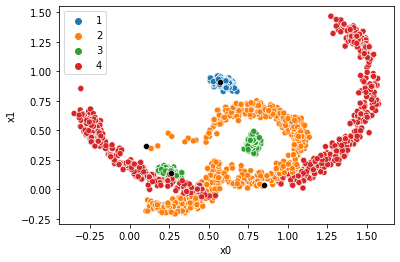

In [7]:
plot_sensors(samples_off)

In [8]:
print(log_prob_fn(tf.constant(
    [[-0.04030127,  0.5771746 ,  1.0083778 ,  0.21558024,  0.77958536, 0.40376794,  0.31509128, -0.27444535]])))
print(log_prob_fn(tf.constant(
    [[0.6030127,  0.9 ,  1.0083778 ,  0.21558024,  0.77958536, 0.40376794,  0.31509128, -0.27444535]])))

tf.Tensor([5.387394], shape=(1,), dtype=float32)
tf.Tensor([-98.090355], shape=(1,), dtype=float32)


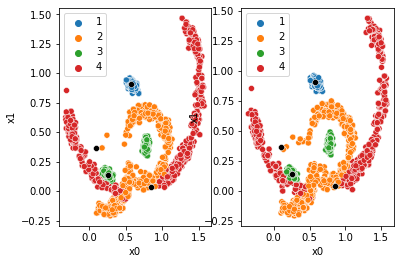

In [9]:
tf.random.set_seed(1)

ntrain = n // 2

samples_init = samples_off

samples_init = tf.random.shuffle(samples_init) # shuffle
samples_init = samples_init[::-1] #!

sample_off_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]

plt.subplot(1, 2, 1)
plot_sensors(sample_off_train)
plt.subplot(1, 2, 2)
plot_sensors(sample_off_test)
plt.show()

In [10]:
threshold = 1e-4 # 1e-2

# start_pts = sample_off_train
start_pts = tf.concat([
        sample_off_train[:(ntrain//2)], 
        tf.random.uniform(shape=(ntrain//2, dim), minval=-1., maxval=1.),
    ], axis=0)

tic = time.perf_counter()
mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold,
                                      max_iterations=10000) #1e-10)
toc = time.perf_counter()
print(f"Optimisation finished in {toc - tic:0.4f} seconds")
len(mode_list)

end pts 1000
Optimisation finished in 173.9702 seconds


8

In [ ]:
# previous num of modes: 6

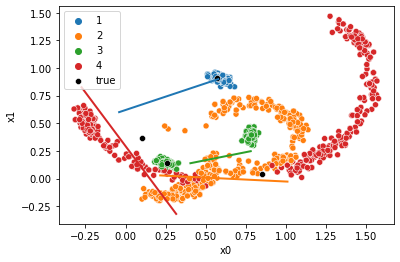

In [25]:
show_jumps(sample_off_train, mode_list=mode_list[:2])

In [26]:
mode_list, inv_hess_list

([<tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.0403011 ,  0.57717955,  1.0084094 ,  0.21560761,  0.7795828 ,
          0.40376103,  0.31512836, -0.27442324], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([ 0.6010137 ,  0.8994251 , -0.02684856,  0.02904511,  0.24810009,
          0.1393157 , -0.3188936 ,  0.8259986 ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([0.60013425, 0.9003874 , 1.07147   , 0.35074416, 0.77970105,
         0.40273878, 1.5049161 , 1.0803405 ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.04039523,  0.58012223,  0.11466104, -0.12579216,  0.24997291,
          0.13788602, -0.7289747 , -0.03377881], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.04015435,  0.5788235 ,  1.0322889 ,  0.55984175,  0.7796818 ,
          0.40510342,  0.56965524,  1.271458  ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.03984733

In [27]:
#! impose inv hessians
inv_hess_list = [tf.eye(8)] * len(inv_hess_list)

In [28]:
# #! select only two modes
# mode_list, inv_hess_list = mode_list[:2], inv_hess_list[:2]

In [29]:
tf.linalg.det(inv_hess_list[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

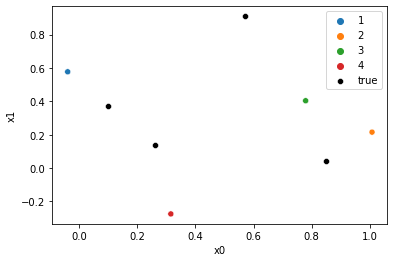

In [30]:
## location of first mode
plot_sensors(tf.stack(mode_list, axis=0)[:1])

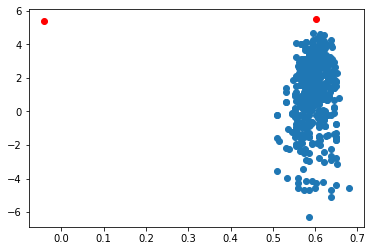

In [58]:
xx = sample_off_train.numpy()
_ = plt.scatter(xx[:, 0], log_prob_fn(xx))
yy = tf.stack(mode_list, axis=0)
_ = plt.scatter(yy[:, 0], log_prob_fn(yy), color="red")

In [31]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

In [32]:
_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

In [33]:
std = 1.048

In [43]:
T = 2000

xx = sample_off_train#[sample_off_train[:, 0] < 0.3]

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=xx, ind_pair_list=ind_pair_list, **proposal_dict)

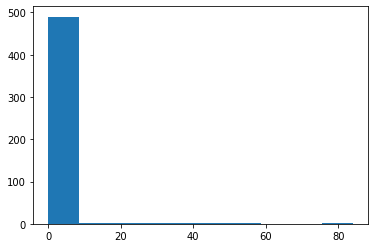

In [44]:
xx = (np.sum(mh.if_accept.numpy() == 1., axis=0)).astype(np.float32)
_ = plt.hist(xx)

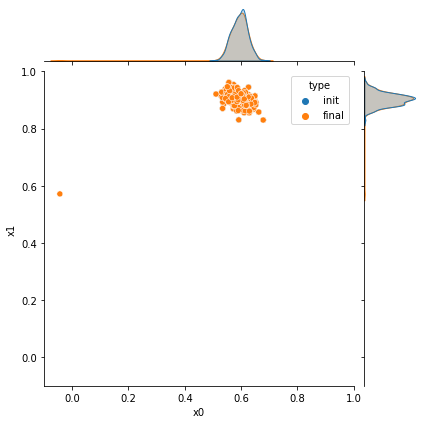

In [45]:
x_all = mh.x #!
# x_all = mh.x[0] #!

x_0 = x_all[0, :, :].numpy()
x_t = x_all[-1, :, :].numpy()

x0_df = pd.DataFrame({f"x{i}": x_0[:, i] for i in range(dim)})
x0_df["type"] = "init"

xt_df = pd.DataFrame({f"x{i}": x_t[:, i] for i in range(dim)})
xt_df["type"] = "final"

xtrain_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
xtrain_df["type"] = "mcmc"


perturbed_df = pd.concat([
#     xtrain_df, 
    x0_df, 
    xt_df], ignore_index=True)

_ = sns.jointplot(data=perturbed_df, x="x0", y="x1", hue="type",
                  xlim=(-.1, 1.),
                  ylim=(-.1, 1.),
 )

In [46]:
np.sum((x_t[:, 0] > 0.2))

499

In [47]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [48]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

In [49]:
_, p_val_no_pert = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)

_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert, "\nafter:", p_val)

before:  0.16229712858926343 
after: 0.16604244694132334


In [20]:
def experiment(n, target_dist, samples_init, sample_init_train, sample_init_test):
    jump_ls = tf.linspace(0.8, 1.2, 51)
    
    ntrain = n // 2
    threshold = 1e-2
    nrep = 1

    num_boot = 800
    alpha = 0.05
    T = 3000
    
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target_dist, kernel=kernel)
    bootstrap = Bootstrap(ksd, n-ntrain)
    
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))

    p_val_list = []
    jump_ratio_list = []

    i = 0
    # sample data
    start_pts = tf.concat([
        sample_init_train[:(ntrain//2)], 
        tf.random.uniform(shape=(ntrain//2, dim), minval=0., maxval=1.)], axis=0)

    plt.subplot(1, 2, 1)
    plot_sensors(sample_off_train)
    plt.subplot(1, 2, 2)
    plot_sensors(sample_off_test)
    plt.show()
    
    # find modes
    print("searching for modes")
    mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold)
    
    #!
    inv_hess_list = [tf.eye(8)] * len(inv_hess_list)

    proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)
    _, ind_pair_list = pairwise_directions(mode_list, return_index=True)

    print("running in parallel ...")
    tic = time.perf_counter()

    # find best jump scale
    mh = MCMCKernel(log_prob=log_prob_fn)
    mh.run(steps=T, std=jump_ls, x_init=sample_init_train, ind_pair_list=ind_pair_list, **proposal_dict)

    # compute ksd
    unscaled_ksd_vals = []
    scaled_ksd_vals = []
    for j in range(jump_ls.shape[0]):
        x_t = mh.x[j, -1, :, :]
        var, ksd_val = ksd.h1_var(X=x_t, Y=tf.identity(x_t), return_scaled_ksd=True)
        ksd_unscaled = ksd_val * tf.math.sqrt(var)
        
        scaled_ksd_vals.append(ksd_val)
        unscaled_ksd_vals.append(ksd_unscaled.numpy())
    
    toc = time.perf_counter()
    print(f"... done in {toc - tic:0.4f} seconds")
    best_jump = jump_ls[tf.math.argmax(scaled_ksd_vals)]

    # mh perturbation
    mh = MCMCKernel(log_prob=log_prob_fn)
    mh.run(steps=T, std=best_jump, x_init=sample_off_test, 
           ind_pair_list=ind_pair_list, **proposal_dict)
    x_0 = mh.x[0, :, :]
    x_t = mh.x[-1, :, :]

    # compute p-value
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target_dist, kernel=kernel)
    bootstrap = Bootstrap(ksd, n)

    multinom_one_sample = multinom_samples[i, :]

    _, p_val0 = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)
    unscaled_ksd0 = bootstrap.ksd_hat
    _, p_valt = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
    unscaled_ksdt = bootstrap.ksd_hat
    
    p_val_list.append(p_val0) # no perturbation
    jump_ratio_list.append(-1.)
    
    p_val_list.append(p_valt)
    jump_ratio_list.append(best_jump.numpy())
        
    res = pd.DataFrame({"pval": p_val_list, "jump": jump_ratio_list, 
                        "ksd": [unscaled_ksd0, unscaled_ksdt]})
    
    return res, unscaled_ksd_vals

2022-05-05 10:10:20.021252: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


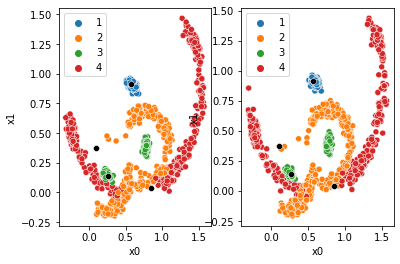

searching for modes
running in parallel ...
... done in 695.6825 seconds
Finished in 928.5214 seconds


In [21]:
tf.random.set_seed(1)
tic = time.perf_counter()
res_df2, unscaled_ksd_vals2 = experiment(n, target, samples_init=samples_off,
                              sample_init_train=sample_off_train,
                              sample_init_test=sample_off_test,
                              )
toc = time.perf_counter()
print(f"Finished in {toc - tic:0.4f} seconds")

In [22]:
res_df2

,pval,jump,ksd
0,0.187266,-1.000,19.806453
1,0.049938,1.048,42.093727


In [24]:
# unscaled_ksd_vals2

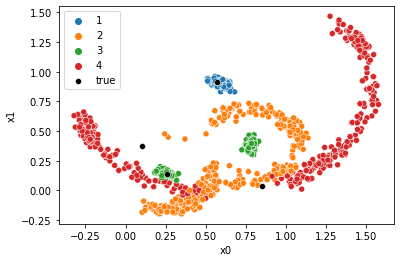

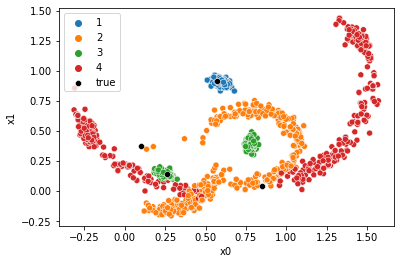

searching for modes
running in parallel ...
... done in 489.8636 seconds
Finished in 678.9540 seconds


In [51]:
tf.random.set_seed(1)
tic = time.perf_counter()
res_df, unscaled_ksd_vals = experiment(n, target, samples_init=samples_off,
                              sample_init_train=sample_off_train,
                              sample_init_test=sample_off_test,
                              )
toc = time.perf_counter()
print(f"Finished in {toc - tic:0.4f} seconds")

In [52]:
print(res_df)

       pval   jump        ksd
0  0.187266 -1.000  19.806453
1  0.059925  1.048  43.789603


In [53]:
unscaled_ksd_vals

[<tf.Tensor: shape=(), dtype=float32, numpy=0.08821374>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.110119075>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.105324045>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11223149>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11167855>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08690038>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09030786>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09819874>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.108263575>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11094536>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.10339948>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.10835774>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.12673712>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09746476>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09867075>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0978272>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.10676732>,
 <tf.Tensor: shape=(), dtype=